### Import python library

In [2]:
import tensorflow as tf
import numpy as np

from tensorflow import keras
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
# from tensorflow.keras.utils import np_utils
from tensorflow.keras.layers import Dense, LSTM, Dropout
import tensorflow.keras.backend as K 

from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler


import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
# import plotly.express as px
# import plotly.graph_objects as go

from math import sqrt

### 1. Read data: augment_24group_1620.csv필요

In [3]:
PCT_lstm_train_X = pd.read_csv("lstmPCT/PCT_lstm_final_train_X.csv")
PCT_lstm_train_y = pd.read_csv("lstmPCT/PCT_lstm_final_train_y.csv")

PCT_lstm_test_X = pd.read_csv("lstmPCT/PCT_lstm_final_test_X.csv")
PCT_lstm_test_y = pd.read_csv("lstmPCT/PCT_lstm_final_test_y.csv")

In [4]:
PCT_lstm_train_y


,T_ID,YEAR,PCT
0,LG,2016,0.375000
1,LG,2016,0.458333
2,LG,2016,0.583333
3,LG,2016,0.333333
4,LG,2016,0.500000
...,...,...,...
1955,OB,2019,0.583333
1956,OB,2019,0.541667
1957,OB,2019,0.583333
1958,OB,2019,0.541667


In [5]:
team = list(PCT_lstm_train_X.T_ID.unique())
year = list(PCT_lstm_train_y.YEAR.unique())

In [6]:
team, year

(['LG', 'HH', 'NC', 'HT', 'SK', 'KT', 'WO', 'LT', 'SS', 'OB'],
 [2016, 2017, 2018, 2019])

#### 4) input shape로 변경 (row, timestep=2, feature)

ex) 
timestep = 2

* X_train_v 구성예시: [[1 ~ 24경기 데이터, 25 ~ 48경기 데이터], [49 ~ 72경기 데이터, 73 ~ 96경기 데이터] ]  
X_train_v.shape >> (2,2*x)             # x: 각 24group에 대한 변수 개수
* y_train_v 구성예시: 97 ~ 120 경기 승률

=> reshape

* X_train_v.shape >> (2,2,x)  # row, timestep, feature

### 2. 모델 구성(LSTM)
- optimizer: RMSprop -> lr(learning rate) 조절
- LSTM: 모델이 계속 동일한 결과값이 나올 때, input 뉴런 개수를 늘려야 한다는 글을 읽고 계속 input 노드 개수를 바꿔주면서 모델 생성중
- loss: MSE

- early_stop: patience를 크게하면 과적합 되는 경우가 있어서 최대한 작게 설정해둠
- batch_size: 모델이 계속 동일한 결과값이 나올 때, 데이터가 적어 batch size를 줄여보라는 글을 읽고 1로 설정해둠

In [7]:
model_dict = dict()
hist_dict = dict()
test_pred_df = pd.DataFrame([],columns = ['YEAR','T_ID','y','y_pred',"shift_PCT_1","shift_PCT_2",'rms','rms_avg'])

idx = 0
for y in year:
    tmp1 = PCT_lstm_train_X[PCT_lstm_train_X["YEAR"] == y]
    tmp2 = PCT_lstm_train_y[PCT_lstm_train_y["YEAR"] == y]
    tmp3 = PCT_lstm_test_X[PCT_lstm_test_X["YEAR"] == y]
    tmp4 = PCT_lstm_test_y[PCT_lstm_test_y["YEAR"] == y]
    for t in team:
        name = '{}{}'.format(y,t)
        print(name,"=======================================")
        
        X_train = tmp1[tmp1["T_ID"] == t].drop(["T_ID","YEAR"],axis = 1)
        y_train = tmp2[tmp2["T_ID"] == t].drop(["T_ID","YEAR"],axis=1)
        X_test = tmp3[tmp3["T_ID"] == t].drop(["T_ID","YEAR"],axis=1)
        y_test = tmp4[tmp4["T_ID"] == t].drop(["T_ID","YEAR"],axis=1)
        
        X_train_v = X_train.values
        y_train_v = y_train.values

        X_test_v = X_test.values
        y_test_v = y_test.values
        
        X_train_t = X_train_v.reshape(X_train_v.shape[0], 2,X_train_v.shape[1]//2)
        X_test_t = X_test_v.reshape(X_test_v.shape[0], 2,X_test_v.shape[1]//2)
        
        ## model
        K.clear_session() 

        model = Sequential()
        optimizer = Adam(lr=0.01)
#         optimizer = RMSprop(lr=0.01, rho=0.9, epsilon=None, decay=0.0)

        model.add(LSTM(100,input_shape = (2,X_train_v.shape[1]//2))) # (timestep, feature)
        model.add(Dense(1)) # output = 1
        model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mae'])

        model.summary()
        
#         hist1 = model.fit(X_train_t, y_train_v, epochs=100, batch_size=1, verbose=1)
        
        early_stop = EarlyStopping(monitor='loss', mode = 'min',patience=2, verbose=1)

        hist1 = model.fit(X_train_t, y_train_v, epochs=100,
                  batch_size=1, verbose=1, callbacks=[early_stop])
        ##
        
        model_dict[name] = model
        hist_dict[name] = hist1
        
        y_pred = model.predict(X_test_t)
        rms = sqrt(mean_squared_error(y_test_v, y_pred))
        rms_avg = sqrt(mean_squared_error(y_test_v,[y_train.mean()[0]]))
        
        
        test_pred_df.loc[idx,:] = [y,t,y_test_v.reshape(-1)[0],y_pred.reshape(-1)[0],
                                  X_test.loc[X_test.index[0],["shift_PCT_1"]][0],
                                  X_test.loc[X_test.index[0],["shift_PCT_2"]][0], rms,rms_avg]

        idx += 1

test_pred_df[['y','y_pred',"shift_PCT_1","shift_PCT_2",'rms','rms_avg']] = test_pred_df[['y','y_pred',"shift_PCT_1","shift_PCT_2",'rms','rms_avg']].astype(float)

2016LG =======================================
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               63200     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 63,301
Trainable params: 63,301
Non-trainable params: 0
_________________________________________________________________
Train on 49 samples
Epoch 1/100
49/49 [==============================] - 3s 68ms/sample - loss: 0.3131 - mae: 0.2610
Epoch 2/100
49/49 [==============================] - 0s 4ms/sample - loss: 0.0225 - mae: 0.1398
Epoch 3/100
49/49 [==============================] - 0s 4ms/sample - loss: 0.0214 - mae: 0.1223
Epoch 4/100
49/49 [==============================] - 0s 5ms/sample - loss: 0.0197 - mae: 0.1247
Epoch 5/100
49/49 [==============================] - 0s 4ms/sa

W0927 22:16:39.978400  7780 callbacks.py:1250] Early stopping conditioned on metric `loss` which is not available. Available metrics are: 


KeyboardInterrupt: 

In [9]:
test_pred_df.sort_values(by=["YEAR","T_ID"]).to_csv("PCT_t2.csv",index = False)

In [10]:
mean_squared_error(test_pred_df['y'],test_pred_df['y_pred'])

0.013307317915064343

c:\users\julia\appdata\local\programs\python\python36\lib\site-packages\numpy\linalg\linalg.py:1974: RuntimeWarning: invalid value encountered in greater
  large = s > cutoff


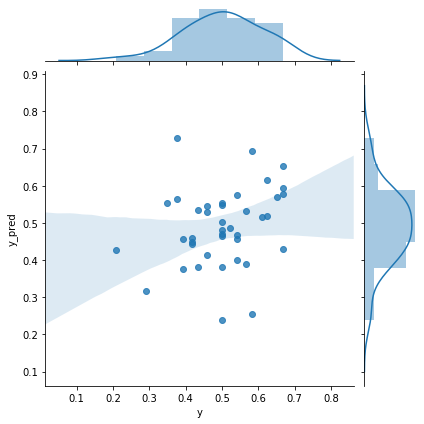

In [9]:
tmp = test_pred_df.copy()
sns.jointplot(x='y',y='y_pred', data=tmp, kind='reg')
plt.show()

In [37]:
test_pred_df.groupby(["YEAR"]).mean()

,y,y_pred,shift_PCT_1,shift_PCT_2,rms,rms0.5
YEAR,,,,,,
2016,0.492391,0.494809,0.504167,0.508514,0.072740,0.075725
2017,0.498370,0.488187,0.491848,0.521937,0.105915,0.076630
2018,0.507971,0.517371,0.500362,0.497480,0.061284,0.071377
2019,0.505072,0.509891,0.508152,0.495290,0.123604,0.105072


In [14]:
ddd.mean().reset_index()

,index,0
0,2016LG_y_pred,0.620275
1,2016LG_rms,0.018753
2,2016HH_y_pred,0.529412
3,2016HH_rms,0.032717
4,2016NC_y_pred,0.521020
5,2016NC_rms,0.044198
6,2016HT_y_pred,0.569602
7,2016HT_rms,0.111269
8,2016SK_y_pred,0.436350
9,2016SK_rms,0.022064


In [10]:
test_pred_df

,YEAR,T_ID,y,y_pred,shift_PCT_1,shift_PCT_2,rms,rms_avg
0,2016,LG,0.608696,0.515102,0.583333,0.458333,0.093594,0.126553
1,2016,HH,0.500000,0.553883,0.500000,0.608696,0.053883,0.031221
2,2016,NC,0.565217,0.532066,0.500000,0.541667,0.033152,0.017857
3,2016,HT,0.458333,0.545200,0.500000,0.583333,0.086866,0.095238
4,2016,SK,0.458333,0.413113,0.458333,0.458333,0.045220,0.040816
5,2016,KT,0.291667,0.316462,0.333333,0.375000,0.024795,0.059524
6,2016,WO,0.375000,0.563730,0.625000,0.666667,0.188730,0.231293
7,2016,LT,0.500000,0.464201,0.375000,0.500000,0.035799,0.041667
8,2016,SS,0.500000,0.380382,0.500000,0.434783,0.119618,0.080708
9,2016,OB,0.666667,0.595040,0.666667,0.458333,0.071627,0.128401


In [5]:
from sklearn.metrics import r2_score
tmp = test_pred_df.copy()
# tmp['half']= 0.5
r2_y_predict = r2_score(tmp['y'], tmp['y_pred'])
r2_y_predict

NameError: name 'test_pred_df' is not defined

#### +======================================+

In [40]:
 #100, lr = 0.01, patience 2 +++, rms ver, rms05 ver, Adam, batch2

test_pred_df

,YEAR,T_ID,y,y_pred,shift_PCT_1,shift_PCT_2,rms,rms0.5
0,2016,LG,0.608696,0.522544,0.583333,0.458333,0.086151,0.108696
1,2016,HH,0.500000,0.510781,0.500000,0.608696,0.010781,0.000000
2,2016,NC,0.565217,0.543209,0.500000,0.541667,0.022008,0.065217
3,2016,HT,0.458333,0.577802,0.500000,0.583333,0.119468,0.041667
4,2016,SK,0.458333,0.522475,0.458333,0.458333,0.064141,0.041667
5,2016,KT,0.291667,0.328833,0.333333,0.375000,0.037166,0.208333
6,2016,WO,0.375000,0.600633,0.625000,0.666667,0.225633,0.125000
7,2016,LT,0.500000,0.470777,0.375000,0.500000,0.029223,0.000000
8,2016,SS,0.500000,0.440369,0.500000,0.434783,0.059631,0.000000
9,2016,OB,0.666667,0.537850,0.666667,0.458333,0.128817,0.166667


In [41]:
test_pred_df.groupby(["YEAR"]).mean()

,y,y_pred,shift_PCT_1,shift_PCT_2,rms,rms0.5
YEAR,,,,,,
2016,0.492391,0.505527,0.504167,0.508514,0.078302,0.075725
2017,0.498370,0.477456,0.491848,0.521937,0.111321,0.076630
2018,0.507971,0.501531,0.500362,0.497480,0.062153,0.071377
2019,0.505072,0.511206,0.508152,0.495290,0.117584,0.105072


In [88]:
test_pred_df #300, lr = 0.01

,YEAR,T_ID,y,y_pred,shift_PCT_1,shift_PCT_2
0,2016,LG,0.608696,0.468182,0.583333,0.458333
1,2016,HH,0.5,0.567216,0.5,0.608696
2,2016,NC,0.565217,0.492161,0.5,0.541667


In [75]:
test_pred_df #300, lr = 0.001

,YEAR,T_ID,y,y_pred,shift_PCT_1,shift_PCT_2
0,2016,LG,0.608696,0.423421,0.583333,0.458333
1,2016,HH,0.5,0.479113,0.5,0.608696


In [86]:
test_pred_df #300, lr = 0.0005

,YEAR,T_ID,y,y_pred,shift_PCT_1,shift_PCT_2
0,2016,LG,0.608696,0.490298,0.583333,0.458333
1,2016,HH,0.5,0.672277,0.5,0.608696
2,2016,NC,0.565217,0.653289,0.5,0.541667


In [96]:
test_pred_df #100, lr = 0.1

,YEAR,T_ID,y,y_pred,shift_PCT_1,shift_PCT_2
0,2016,LG,0.608696,2.45143,0.583333,0.458333
1,2016,HH,0.5,-2.15025,0.5,0.608696
2,2016,NC,0.565217,-1.5099,0.5,0.541667


In [104]:
test_pred_df #100, lr = 0.01, patience 3

,YEAR,T_ID,y,y_pred,shift_PCT_1,shift_PCT_2
0,2016,LG,0.608696,0.46766,0.583333,0.458333
1,2016,HH,0.5,0.554741,0.5,0.608696
2,2016,NC,0.565217,0.540454,0.5,0.541667
3,2016,HT,0.458333,0.586706,0.5,0.583333
4,2016,SK,0.458333,0.492073,0.458333,0.458333
5,2016,KT,0.291667,0.450251,0.333333,0.375
6,2016,WO,0.375,0.629395,0.625,0.666667
7,2016,LT,0.5,0.417594,0.375,0.5
8,2016,SS,0.5,0.488712,0.5,0.434783
9,2016,OB,0.666667,0.553688,0.666667,0.458333


In [102]:
test_pred_df #100, lr = 0.01, patience 1

,YEAR,T_ID,y,y_pred,shift_PCT_1,shift_PCT_2
0,2016,LG,0.608696,0.477605,0.583333,0.458333
1,2016,HH,0.5,0.509489,0.5,0.608696
2,2016,NC,0.565217,0.519098,0.5,0.541667
3,2016,HT,0.458333,0.585744,0.5,0.583333
4,2016,SK,0.458333,0.462029,0.458333,0.458333
5,2016,KT,0.291667,0.333392,0.333333,0.375
6,2016,WO,0.375,0.543434,0.625,0.666667
7,2016,LT,0.5,0.377705,0.375,0.5
8,2016,SS,0.5,0.400355,0.5,0.434783
9,2016,OB,0.666667,0.539122,0.666667,0.458333


In [7]:
 #100, lr = 0.01, patience 2 +++, rms ver, rms05 ver, Adam

test_pred_df

,YEAR,T_ID,y,y_pred,shift_PCT_1,shift_PCT_2,rms,rms0.5
0,2016,LG,0.608696,0.506664,0.583333,0.458333,0.102032,0.108696
1,2016,HH,0.5,0.518261,0.5,0.608696,0.0182612,0
2,2016,NC,0.565217,0.520184,0.5,0.541667,0.0450339,0.0652174
3,2016,HT,0.458333,0.562111,0.5,0.583333,0.103777,0.0416667
4,2016,SK,0.458333,0.487501,0.458333,0.458333,0.0291681,0.0416667
5,2016,KT,0.291667,0.372884,0.333333,0.375,0.0812176,0.208333
6,2016,WO,0.375,0.578908,0.625,0.666667,0.203908,0.125
7,2016,LT,0.5,0.431082,0.375,0.5,0.0689185,0
8,2016,SS,0.5,0.4259,0.5,0.434783,0.0740999,0
9,2016,OB,0.666667,0.496237,0.666667,0.458333,0.170429,0.166667


In [139]:
 #100, lr = 0.01, patience 2 +++, rms ver, rms05 ver
# model_copy = model_dict.copy()
# hist_copy = hist_dict.copy()
# tmp_df = test_pred_df.copy()
tmp_df

,YEAR,T_ID,y,y_pred,shift_PCT_1,shift_PCT_2,rms,rms0.5
0,2016,LG,0.608696,0.612487,0.583333,0.458333,0.00379184,0.108696
1,2016,HH,0.5,0.434664,0.5,0.608696,0.0653357,0
2,2016,NC,0.565217,0.529742,0.5,0.541667,0.0354756,0.0652174
3,2016,HT,0.458333,0.542623,0.5,0.583333,0.0842892,0.0416667
4,2016,SK,0.458333,0.442084,0.458333,0.458333,0.0162496,0.0416667
5,2016,KT,0.291667,0.350306,0.333333,0.375,0.0586392,0.208333
6,2016,WO,0.375,0.586355,0.625,0.666667,0.211355,0.125
7,2016,LT,0.5,0.475668,0.375,0.5,0.0243322,0
8,2016,SS,0.5,0.475334,0.5,0.434783,0.024666,0
9,2016,OB,0.666667,0.537623,0.666667,0.458333,0.129044,0.166667


In [132]:
test_pred_df #100, lr = 0.01, patience 2 +++, rms ver

,YEAR,T_ID,y,y_pred,shift_PCT_1,shift_PCT_2,rms
0,2016,LG,0.608696,0.287378,0.583333,0.458333,0.321318
1,2016,HH,0.5,0.582811,0.5,0.608696,0.0828107
2,2016,NC,0.565217,0.587976,0.5,0.541667,0.0227588
3,2016,HT,0.458333,0.542857,0.5,0.583333,0.0845234
4,2016,SK,0.458333,0.453548,0.458333,0.458333,0.00478577
5,2016,KT,0.291667,0.332341,0.333333,0.375,0.0406745
6,2016,WO,0.375,0.544543,0.625,0.666667,0.169543
7,2016,LT,0.5,0.41319,0.375,0.5,0.0868104
8,2016,SS,0.5,0.434083,0.5,0.434783,0.0659173
9,2016,OB,0.666667,0.746169,0.666667,0.458333,0.0795019


In [106]:
test_pred_df #100, lr = 0.01, patience 2 ++

,YEAR,T_ID,y,y_pred,shift_PCT_1,shift_PCT_2
0,2016,LG,0.608696,0.435018,0.583333,0.458333
1,2016,HH,0.5,0.534284,0.5,0.608696
2,2016,NC,0.565217,0.626261,0.5,0.541667
3,2016,HT,0.458333,0.544398,0.5,0.583333
4,2016,SK,0.458333,0.556326,0.458333,0.458333
5,2016,KT,0.291667,0.371262,0.333333,0.375
6,2016,WO,0.375,0.670688,0.625,0.666667
7,2016,LT,0.5,0.443552,0.375,0.5
8,2016,SS,0.5,0.401195,0.5,0.434783
9,2016,OB,0.666667,0.483709,0.666667,0.458333


In [100]:
test_pred_df #100, lr = 0.01, patience 2

,YEAR,T_ID,y,y_pred,shift_PCT_1,shift_PCT_2
0,2016,LG,0.608696,0.288105,0.583333,0.458333
1,2016,HH,0.5,0.504434,0.5,0.608696
2,2016,NC,0.565217,0.539863,0.5,0.541667
3,2016,HT,0.458333,0.548684,0.5,0.583333
4,2016,SK,0.458333,0.418596,0.458333,0.458333
5,2016,KT,0.291667,0.35347,0.333333,0.375
6,2016,WO,0.375,0.663121,0.625,0.666667
7,2016,LT,0.5,0.495439,0.375,0.5
8,2016,SS,0.5,0.383013,0.5,0.434783
9,2016,OB,0.666667,0.541724,0.666667,0.458333


In [90]:
test_pred_df #100, lr = 0.01

,YEAR,T_ID,y,y_pred,shift_PCT_1,shift_PCT_2
0,2016,LG,0.608696,0.467328,0.583333,0.458333
1,2016,HH,0.5,0.527652,0.5,0.608696
2,2016,NC,0.565217,0.52047,0.5,0.541667
3,2016,HT,0.458333,0.429098,0.5,0.583333
4,2016,SK,0.458333,0.4829,0.458333,0.458333


In [94]:
test_pred_df #100, lr = 0.001

,YEAR,T_ID,y,y_pred,shift_PCT_1,shift_PCT_2
0,2016,LG,0.608696,0.542802,0.583333,0.458333
1,2016,HH,0.5,0.545997,0.5,0.608696
2,2016,NC,0.565217,0.567216,0.5,0.541667
3,2016,HT,0.458333,0.577572,0.5,0.583333
4,2016,SK,0.458333,0.604854,0.458333,0.458333
5,2016,KT,0.291667,0.42159,0.333333,0.375
6,2016,WO,0.375,0.598227,0.625,0.666667
7,2016,LT,0.5,0.386472,0.375,0.5
8,2016,SS,0.5,0.329622,0.5,0.434783


In [73]:
test_pred_df #100, lr = 0.001

,YEAR,T_ID,y,y_pred,shift_PCT_1,shift_PCT_2
0,2016,LG,0.608696,0.478348,0.583333,0.458333
1,2016,HH,0.5,0.529292,0.5,0.608696


In [92]:
test_pred_df #100, lr=0.0005

,YEAR,T_ID,y,y_pred,shift_PCT_1,shift_PCT_2
0,2016,LG,0.608696,0.494715,0.583333,0.458333
1,2016,HH,0.5,0.630847,0.5,0.608696
2,2016,NC,0.565217,0.489612,0.5,0.541667
3,2016,HT,0.458333,0.593727,0.5,0.583333
4,2016,SK,0.458333,0.523688,0.458333,0.458333
5,2016,KT,0.291667,0.243116,0.333333,0.375
6,2016,WO,0.375,0.637864,0.625,0.666667
7,2016,LT,0.5,0.400517,0.375,0.5
8,2016,SS,0.5,0.314818,0.5,0.434783


In [98]:
test_pred_df #200, lr = 0.01

,YEAR,T_ID,y,y_pred,shift_PCT_1,shift_PCT_2
0,2016,LG,0.608696,0.545502,0.583333,0.458333
1,2016,HH,0.5,0.636396,0.5,0.608696
2,2016,NC,0.565217,0.607057,0.5,0.541667
3,2016,HT,0.458333,0.607852,0.5,0.583333
4,2016,SK,0.458333,0.419407,0.458333,0.458333
5,2016,KT,0.291667,0.42172,0.333333,0.375
6,2016,WO,0.375,0.52766,0.625,0.666667
7,2016,LT,0.5,0.30456,0.375,0.5
8,2016,SS,0.5,0.501613,0.5,0.434783
9,2016,OB,0.666667,0.591436,0.666667,0.458333


In [79]:
test_pred_df #200, lr = 0.001

,YEAR,T_ID,y,y_pred,shift_PCT_1,shift_PCT_2
0,2016,LG,0.608696,0.392572,0.583333,0.458333
1,2016,HH,0.5,0.548009,0.5,0.608696


In [81]:
test_pred_df #200, lr=0.0005

,YEAR,T_ID,y,y_pred,shift_PCT_1,shift_PCT_2
0,2016,LG,0.608696,0.513151,0.583333,0.458333
1,2016,HH,0.5,0.573316,0.5,0.608696
2,2016,NC,0.565217,0.635897,0.5,0.541667
3,2016,HT,0.458333,0.470724,0.5,0.583333


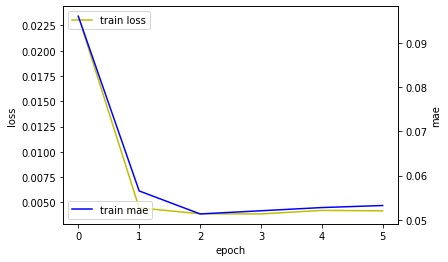

In [76]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist1.history['loss'], 'y', label='train loss')

acc_ax.plot(hist1.history['mae'], 'b', label='train mae')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('mae')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()